<a href="https://www.kaggle.com/code/samamostafa03/genres-and-styles-classification?scriptVersionId=231926660" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

Core Libraries:

In [1]:
import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2" 
os.environ["KERAS_BACKEND"] = "tensorflow"
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import keras
from keras import ops
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_datasets as tfds
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as transforms
import torchvision.models as models
from torch.utils.data import Dataset, DataLoader, get_worker_info
import timm
from timm.data import Mixup
from timm.data.constants import IMAGENET_DEFAULT_MEAN, IMAGENET_DEFAULT_STD
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.image as mpimg
import cv2
from tqdm.notebook import tqdm
import gc
from sklearn.preprocessing import StandardScaler, LabelBinarizer
from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from scipy.ndimage import rotate
import itertools
%matplotlib inline
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from collections import Counter
from sklearn.metrics import accuracy_score,roc_curve,auc
from sklearn.preprocessing import label_binarize
from PIL import Image
sns.set(style='white', context='notebook', palette='deep')

WikiArt Dataset:

In [2]:
# Load and map genres, styles classes
datapath = '/kaggle/input/wikiart'
genres_datapath = '/kaggle/input/genres-ds'
styles_datapath = '/kaggle/input/style-ds'

def process_classes(data_path,file_name):
    file_path =  data_path+'/'+file_name+'.txt'
    classes = {}
    with open(file_path, 'r') as f:
        for line in f:
            index, label = line.strip().split(' ', 1)
            classes[int(index)] = label
    return classes

genres_classes = process_classes(genres_datapath,'genre_class')
styles_classes = process_classes(styles_datapath,'style_class')
print(f"Genres:\n{genres_classes}\n")
print(f"Styles:\n{styles_classes}")

Genres:
{0: 'abstract_painting', 1: 'cityscape', 2: 'genre_painting', 3: 'illustration', 4: 'landscape', 5: 'nude_painting', 6: 'portrait', 7: 'religious_painting', 8: 'sketch_and_study', 9: 'still_life'}

Styles:
{0: 'Abstract_Expressionism', 1: 'Action_painting', 2: 'Analytical_Cubism', 3: 'Art_Nouveau', 4: 'Baroque', 5: 'Color_Field_Painting', 6: 'Contemporary_Realism', 7: 'Cubism', 8: 'Early_Renaissance', 9: 'Expressionism', 10: 'Fauvism', 11: 'High_Renaissance', 12: 'Impressionism', 13: 'Mannerism_Late_Renaissance', 14: 'Minimalism', 15: 'Naive_Art_Primitivism', 16: 'New_Realism', 17: 'Northern_Renaissance', 18: 'Pointillism', 19: 'Pop_Art', 20: 'Post_Impressionism', 21: 'Realism', 22: 'Rococo', 23: 'Romanticism', 24: 'Symbolism', 25: 'Synthetic_Cubism', 26: 'Ukiyo_e'}


In [3]:
# Load train and validation data
genre_data_valid = pd.read_csv(genres_datapath+'/genre_val.csv')
genre_data_train = pd.read_csv(genres_datapath+'/genre_train.csv')
genre_data_train.head()

,filename,genre
0,Post_Impressionism/vincent-van-gogh_ears-of-wh...,4
1,Symbolism/theodor-severin-kittelsen_kvitebj-rn...,3
2,Expressionism/martiros-saryan_mother-of-the-ar...,6
3,Early_Renaissance/leonardo-da-vinci_study-for-...,8
4,Expressionism/jose-gutierrez-solana_old-mounta...,6


In [4]:
style_data_valid = pd.read_csv(
    styles_datapath + '/style_val.csv',
    header=None,
    names=['filename', 'style']
)
style_data_train = pd.read_csv(
    styles_datapath + '/style_train.csv',
    header=None,
    names=['filename', 'style']
)
style_data_train.head()

,filename,style
0,Impressionism/edgar-degas_landscape-on-the-orn...,12
1,Realism/camille-corot_mantes-cathedral.jpg,21
2,Abstract_Expressionism/gene-davis_untitled-197...,0
3,Symbolism/kuzma-petrov-vodkin_in-the-1920.jpg,24
4,Impressionism/maurice-prendergast_paris-boulev...,12


In [5]:
# Merge datasets on filename (assuming filenames are unique and match)
data_train = pd.merge(genre_data_train, style_data_train, on='filename', suffixes=('_genre', '_style'))
data_valid = pd.merge(genre_data_valid , style_data_valid , on='filename', suffixes=('_genre', '_style'))
data_train.head()

,filename,genre,style
0,Post_Impressionism/vincent-van-gogh_ears-of-wh...,4,20
1,Symbolism/theodor-severin-kittelsen_kvitebj-rn...,3,24
2,Expressionism/martiros-saryan_mother-of-the-ar...,6,9
3,Early_Renaissance/leonardo-da-vinci_study-for-...,8,8
4,Expressionism/jose-gutierrez-solana_old-mounta...,6,9


In [6]:
# Check for missing values
print(f"train:\n{data_train.isnull().sum()}\n")
print(f"validation:\n{data_valid.isnull().sum()}")

train:
filename    0
genre       0
style       0
dtype: int64

validation:
filename    0
genre       0
style       0
dtype: int64


In [7]:
# Identify invalid filenames
def find_invalid_filenames(dataframe, base_dir):
    invalid_files = []
    for filename in dataframe['filename']:
        file_path = os.path.join(base_dir, filename)
        if not os.path.isfile(file_path):
            invalid_files.append(filename)
    return invalid_files

invalid_filenames_train = find_invalid_filenames(data_train, datapath)
invalid_filenames_valid = find_invalid_filenames(data_valid, datapath)

print(f"Number of invalid files in train data: {len(invalid_filenames_train)}")
print(f"Number of invalid files in valid data: {len(invalid_filenames_valid)}")

Number of invalid files in train data: 421
Number of invalid files in valid data: 191


In [8]:
# Remove invalid filenames from both train and validation datasets
data_train_cleaned = data_train[~data_train['filename'].isin(invalid_filenames_train)]
print(f"Number of valid rows in train after cleaning: {len(data_train_cleaned)}")

data_valid_cleaned = data_valid[~data_valid['filename'].isin(invalid_filenames_valid)]
print(f"Number of valid rows in valid after cleaning: {len(data_valid_cleaned)}")

Number of valid rows in train after cleaning: 44868
Number of valid rows in valid after cleaning: 19149


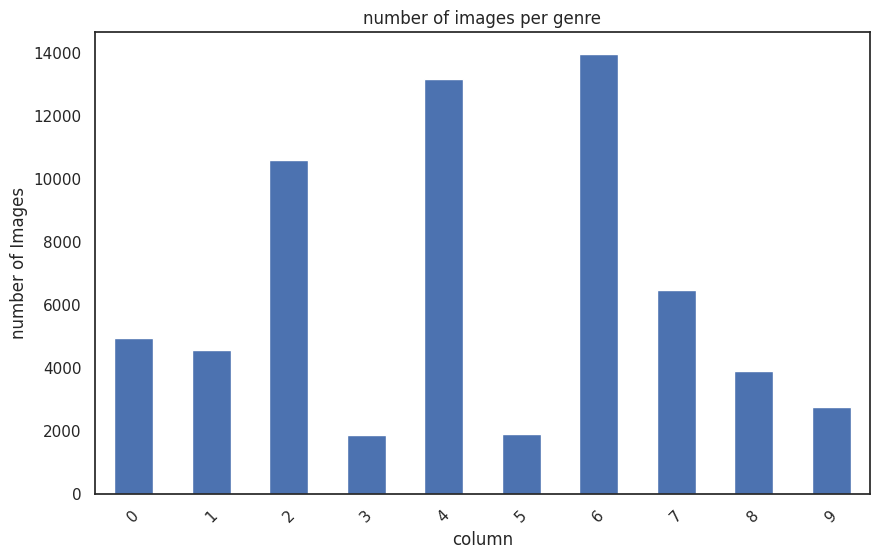

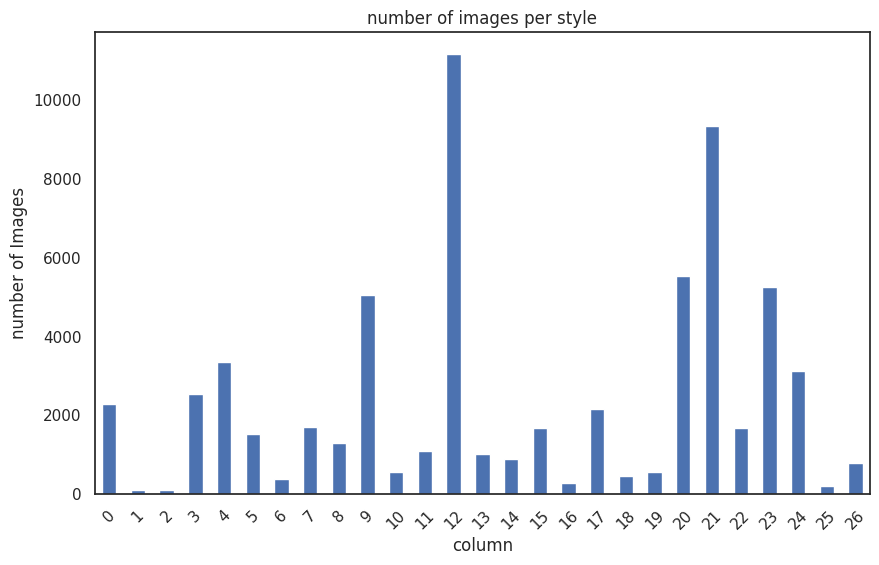

In [9]:
# Visualize the genres , styles distribution
def visualize_data(data_train,data_val,column,classes):
    combined_data = (data_train_cleaned[column].value_counts() + data_valid_cleaned[column].value_counts())
    combined_data.sort_index().plot(kind='bar', figsize=(10, 6), legend=False)
    plt.title(f"number of images per {column}")
    plt.ylabel("number of Images")
    plt.xlabel('column')
    plt.xticks(rotation=45)
    plt.show()
visualize_data(data_train_cleaned,data_valid_cleaned,'genre',genres_classes)
visualize_data(data_train_cleaned,data_valid_cleaned,'style',styles_classes)

In [10]:
# Extract features and labels
train_images = data_train_cleaned["filename"].values
genre_train_labels = data_train_cleaned["genre"].values
style_train_labels = data_train_cleaned["style"].values

valid_images = data_valid_cleaned["filename"].values
genre_valid_labels = data_valid_cleaned["genre"].values
style_valid_labels = data_valid_cleaned["style"].values

# Convert to TensorFlow datasets
genre_train_ds = tf.data.Dataset.from_tensor_slices((train_images, genre_train_labels))
genre_validation_ds = tf.data.Dataset.from_tensor_slices((valid_images, genre_valid_labels))

style_train_ds = tf.data.Dataset.from_tensor_slices((train_images, style_train_labels))
style_validation_ds = tf.data.Dataset.from_tensor_slices((valid_images, style_valid_labels))

for sample in genre_train_ds.take(5):  # Take first 5 samples
    print(sample)

(<tf.Tensor: shape=(), dtype=string, numpy=b'Post_Impressionism/vincent-van-gogh_ears-of-wheat-1890(1).jpg'>, <tf.Tensor: shape=(), dtype=int64, numpy=4>)
(<tf.Tensor: shape=(), dtype=string, numpy=b'Symbolism/theodor-severin-kittelsen_kvitebj-rn-kong-valemon-1912-2.jpg'>, <tf.Tensor: shape=(), dtype=int64, numpy=3>)
(<tf.Tensor: shape=(), dtype=string, numpy=b'Expressionism/martiros-saryan_mother-of-the-artist-1904.jpg'>, <tf.Tensor: shape=(), dtype=int64, numpy=6>)
(<tf.Tensor: shape=(), dtype=string, numpy=b'Early_Renaissance/leonardo-da-vinci_study-for-the-madonna-with-the-fruit-bowl.jpg'>, <tf.Tensor: shape=(), dtype=int64, numpy=8>)
(<tf.Tensor: shape=(), dtype=string, numpy=b'Expressionism/jose-gutierrez-solana_old-mountain.jpg'>, <tf.Tensor: shape=(), dtype=int64, numpy=6>)


In [11]:
RESIZE_TO = 384
CROP_TO = 224
BATCH_SIZE = 64
AUTO = tf.data.AUTOTUNE  # optimise the pipeline performance
NUM_CLASSES = 10  # number of classes
SCHEDULE_LENGTH = (
    500  # we will train on lower resolution images and will still attain good results
)
SCHEDULE_BOUNDARIES = [
    200,
    300,
    400,
]  # more the dataset size the schedule length increase

SCHEDULE_LENGTH = SCHEDULE_LENGTH * 512 / BATCH_SIZE

random_flip = keras.layers.RandomFlip("horizontal")
random_crop = keras.layers.RandomCrop(CROP_TO, CROP_TO)

def preprocess_train(image, label):
    image_path = tf.strings.join([datapath, "/", image])
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = random_flip(image)
    image = ops.image.resize(image, (RESIZE_TO, RESIZE_TO))
    image = random_crop(image)
    image = image / 255.0
    return (image, label)


def preprocess_test(image, label):
    image_path = tf.strings.join([datapath, "/", image])
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = ops.image.resize(image, (RESIZE_TO, RESIZE_TO))
    image = ops.cast(image, dtype="float32")
    image = image / 255.0
    return (image, label)


DATASET_NUM_TRAIN_EXAMPLES = genre_train_ds.cardinality().numpy()
STEPS_PER_EPOCH = DATASET_NUM_TRAIN_EXAMPLES // BATCH_SIZE

repeat_count = int(
    SCHEDULE_LENGTH * BATCH_SIZE / DATASET_NUM_TRAIN_EXAMPLES * STEPS_PER_EPOCH
)
repeat_count += 4 + 1
# Training pipeline
pipeline_train = (
    genre_train_ds.shuffle(100)
    .repeat(repeat_count)  # Repeat dataset_size / num_steps
    .map(preprocess_train, num_parallel_calls=AUTO)
    .batch(BATCH_SIZE)
    .prefetch(AUTO)
)

# Validation pipeline
pipeline_validation = (
    genre_validation_ds.map(preprocess_test, num_parallel_calls=AUTO)
    .batch(BATCH_SIZE)
    .prefetch(AUTO)
)

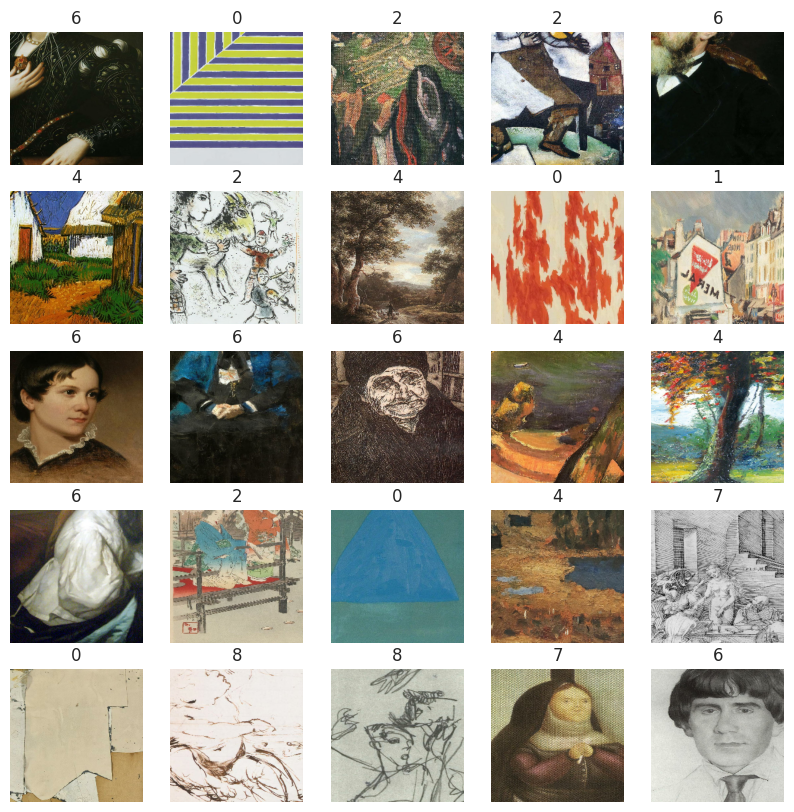

In [12]:
image_batch, label_batch = next(iter(pipeline_train))

plt.figure(figsize=(10, 10))
for n in range(25):
    ax = plt.subplot(5, 5, n + 1)
    plt.imshow(image_batch[n])
    plt.title(label_batch[n].numpy())
    plt.axis("off")

In [13]:
bit_model_url = "https://tfhub.dev/google/bit/m-r50x3/1"
bit_module = hub.load(bit_model_url)

In [14]:
class MyBiTModel(keras.Model):
    def __init__(self, num_classes, module, **kwargs):
        super().__init__(**kwargs)
        self.num_classes = num_classes
        self.head = keras.layers.Dense(num_classes, kernel_initializer="zeros")
        self.bit_model = module
    def call(self, images):
        bit_embedding = self.bit_model(images)
        return self.head(bit_embedding)

In [15]:
strategy = tf.distribute.MirroredStrategy()
print("Number of devices: ", strategy.num_replicas_in_sync)
NUM_CLASSES = 10
# Define model, optimizer, etc. INSIDE the strategy scope
with strategy.scope():
    model = MyBiTModel(num_classes=10, module=bit_module)

    learning_rate = 0.003 * BATCH_SIZE / 512
    lr_schedule = keras.optimizers.schedules.PiecewiseConstantDecay(
        boundaries=SCHEDULE_BOUNDARIES,
        values=[
            learning_rate,
            learning_rate * 0.1,
            learning_rate * 0.01,
            learning_rate * 0.001,
        ],
    )

    optimizer = keras.optimizers.SGD(learning_rate=lr_schedule, momentum=0.9)
    loss_fn = keras.losses.SparseCategoricalCrossentropy(from_logits=True)

    model.compile(optimizer=optimizer, loss=loss_fn, metrics=["accuracy"])


Number of devices:  2


In [16]:
model.compile(optimizer=optimizer, loss=loss_fn, metrics=["accuracy"])
train_callbacks = [
    keras.callbacks.EarlyStopping(
        monitor="val_accuracy", patience=2, restore_best_weights=True
    )
]

genre_history = model.fit(
    pipeline_train,
    batch_size=BATCH_SIZE,
    epochs=5,
    steps_per_epoch=STEPS_PER_EPOCH,
    validation_data=pipeline_validation,
    callbacks=train_callbacks,
)

Epoch 1/5
701/701 ━━━━━━━━━━━━━━━━━━━━ 3470s 5s/step - accuracy: 0.6265 - loss: 1.2144 - val_accuracy: 0.7372 - val_loss: 0.7862
Epoch 2/5
701/701 ━━━━━━━━━━━━━━━━━━━━ 3417s 5s/step - accuracy: 0.7184 - loss: 0.8489 - val_accuracy: 0.7352 - val_loss: 0.7842
Epoch 3/5
701/701 ━━━━━━━━━━━━━━━━━━━━ 3421s 5s/step - accuracy: 0.7190 - loss: 0.8379 - val_accuracy: 0.7365 - val_loss: 0.7812


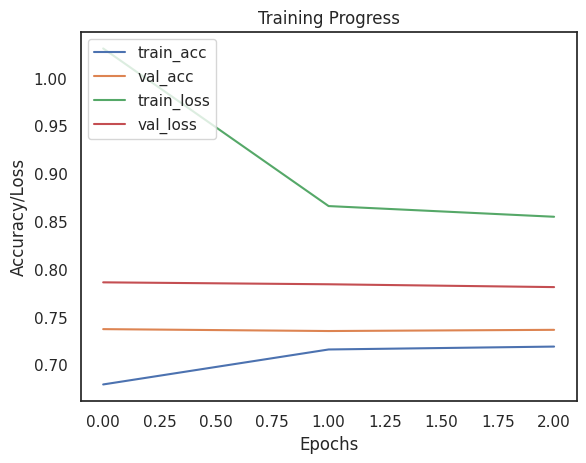

In [17]:
model.save("best_genre_model.h5") 

def plot_hist(hist):
    plt.plot(hist.history["accuracy"])
    plt.plot(hist.history["val_accuracy"])
    plt.plot(hist.history["loss"])
    plt.plot(hist.history["val_loss"])
    plt.title("Training Progress")
    plt.ylabel("Accuracy/Loss")
    plt.xlabel("Epochs")
    plt.legend(["train_acc", "val_acc", "train_loss", "val_loss"], loc="upper left")
    plt.show()


plot_hist(genre_history)

In [18]:
accuracy = model.evaluate(pipeline_validation)[1] * 100
print("Accuracy: {:.2f}%".format(accuracy))

300/300 ━━━━━━━━━━━━━━━━━━━━ 906s 3s/step - accuracy: 0.6295 - loss: 1.0580
Accuracy: 73.72%


In [19]:
def get_predictions(model, pipeline_validation, num_classes):
    y_true = []
    y_pred = []
    y_probs = []

    for images, labels in pipeline_validation:
        probs = model.predict(images)
        y_probs.extend(probs)
        y_pred.extend(np.argmax(probs, axis=1))
        y_true.extend(labels.numpy())

    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    y_probs = np.array(y_probs)

    # One-hot encode for ROC
    y_true_bin = label_binarize(y_true, classes=list(range(num_classes)))

    return y_true, y_pred, y_probs, y_true_bin

def show_classification_report(y_true, y_pred):
    print("Classification Report:\n")
    print(classification_report(y_true, y_pred))

def plot_confusion_matrix(y_true, y_pred, class_names=None):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted Labels")
    plt.ylabel("True Labels")
    plt.show()

def plot_roc_curves(y_true_bin, y_probs, num_classes):
    fpr = {}
    tpr = {}
    roc_auc = {}

    for i in range(num_classes):
        fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_probs[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    plt.figure(figsize=(10, 8))
    for i in range(num_classes):
        plt.plot(fpr[i], tpr[i], label=f"Class {i} (AUC = {roc_auc[i]:.2f})")

    plt.plot([0, 1], [0, 1], "k--")
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("Multi-Class ROC Curve")
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.show()

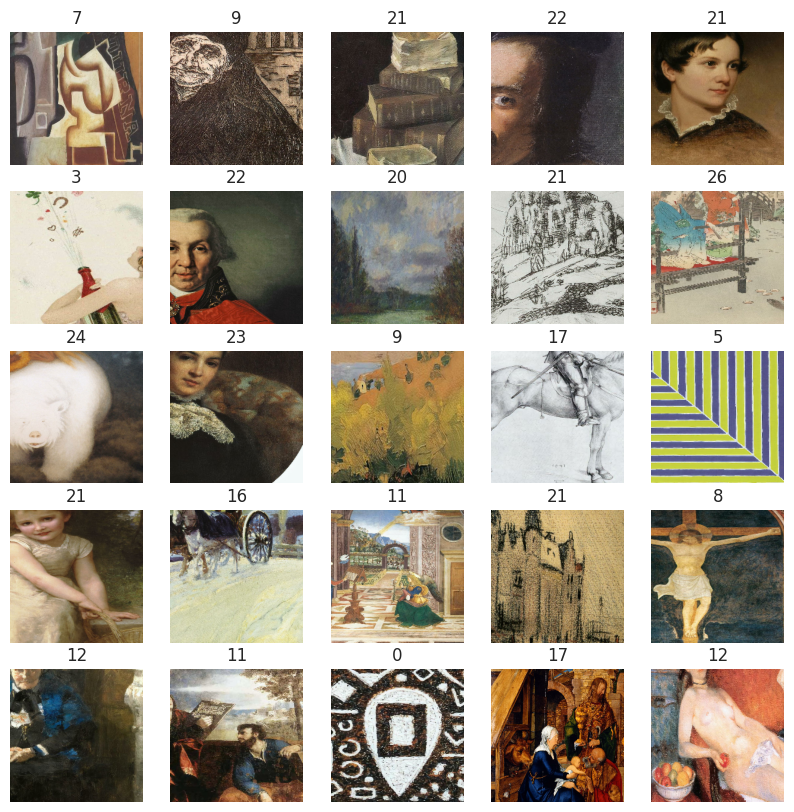

In [20]:
# Training pipeline
pipeline_train = (
    style_train_ds.shuffle(100)
    .repeat(repeat_count)  # Repeat dataset_size / num_steps
    .map(preprocess_train, num_parallel_calls=AUTO)
    .batch(BATCH_SIZE)
    .prefetch(AUTO)
)

# Validation pipeline
pipeline_validation = (
    style_validation_ds.map(preprocess_test, num_parallel_calls=AUTO)
    .batch(BATCH_SIZE)
    .prefetch(AUTO)
)

image_batch, label_batch = next(iter(pipeline_train))

plt.figure(figsize=(10, 10))
for n in range(25):
    ax = plt.subplot(5, 5, n + 1)
    plt.imshow(image_batch[n])
    plt.title(label_batch[n].numpy())
    plt.axis("off")

In [21]:
strategy = tf.distribute.MirroredStrategy()
NUM_CLASSES = 27
# Define model, optimizer, etc. INSIDE the strategy scope
with strategy.scope():
    model = MyBiTModel(num_classes=27, module=bit_module)

    learning_rate = 0.003 * BATCH_SIZE / 512
    lr_schedule = keras.optimizers.schedules.PiecewiseConstantDecay(
        boundaries=SCHEDULE_BOUNDARIES,
        values=[
            learning_rate,
            learning_rate * 0.1,
            learning_rate * 0.01,
            learning_rate * 0.001,
        ],
    )

    optimizer = keras.optimizers.SGD(learning_rate=lr_schedule, momentum=0.9)
    loss_fn = keras.losses.SparseCategoricalCrossentropy(from_logits=True)

    model.compile(optimizer=optimizer, loss=loss_fn, metrics=["accuracy"])

model.compile(optimizer=optimizer, loss=loss_fn, metrics=["accuracy"])
train_callbacks = [
    keras.callbacks.EarlyStopping(
        monitor="val_accuracy", patience=2, restore_best_weights=True
    )
]
STEPS_PER_EPOCH = DATASET_NUM_TRAIN_EXAMPLES // BATCH_SIZE

style_history = model.fit(
    pipeline_train,
    batch_size=BATCH_SIZE,
    epochs=5,
    steps_per_epoch=STEPS_PER_EPOCH,
    validation_data=pipeline_validation,
    callbacks=train_callbacks,
)

Epoch 1/5
701/701 ━━━━━━━━━━━━━━━━━━━━ 3899s 6s/step - accuracy: 0.3766 - loss: 2.1775 - val_accuracy: 0.4989 - val_loss: 1.5083
Epoch 2/5
701/701 ━━━━━━━━━━━━━━━━━━━━ 3818s 5s/step - accuracy: 0.5101 - loss: 1.5154 - val_accuracy: 0.5004 - val_loss: 1.5008
Epoch 3/5
701/701 ━━━━━━━━━━━━━━━━━━━━ 3801s 5s/step - accuracy: 0.5096 - loss: 1.5149 - val_accuracy: 0.5028 - val_loss: 1.4961
Epoch 4/5
701/701 ━━━━━━━━━━━━━━━━━━━━ 3748s 5s/step - accuracy: 0.5089 - loss: 1.5063 - val_accuracy: 0.5032 - val_loss: 1.4925
Epoch 5/5
701/701 ━━━━━━━━━━━━━━━━━━━━ 3738s 5s/step - accuracy: 0.5098 - loss: 1.5016 - val_accuracy: 0.5052 - val_loss: 1.4881


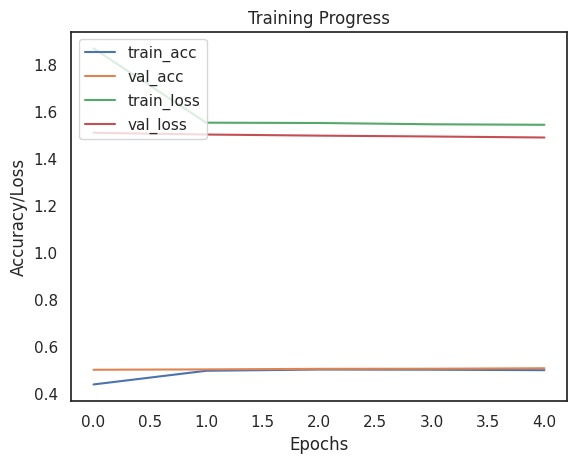

In [22]:
model.save("best_style_model.h5") 
def plot_hist(hist):
    plt.plot(hist.history["accuracy"])
    plt.plot(hist.history["val_accuracy"])
    plt.plot(hist.history["loss"])
    plt.plot(hist.history["val_loss"])
    plt.title("Training Progress")
    plt.ylabel("Accuracy/Loss")
    plt.xlabel("Epochs")
    plt.legend(["train_acc", "val_acc", "train_loss", "val_loss"], loc="upper left")
    plt.show()


plot_hist(style_history)

In [23]:
accuracy = model.evaluate(pipeline_validation)[1] * 100
print("Accuracy: {:.2f}%".format(accuracy))

300/300 ━━━━━━━━━━━━━━━━━━━━ 1368s 5s/step - accuracy: 0.4961 - loss: 1.5268
Accuracy: 50.52%
